In [19]:
# ==============================
# Section 1: Import Libraries
# ==============================
import cv2
import os
import numpy as np
from ultralytics import YOLO
from fpdf import FPDF
import matplotlib.pyplot as plt

In [20]:
# ==============================
# Section 2: Configurations
# ==============================
video_path = r"F:\DS\Train Wagon Pipeline\DHN-upper-side-view-2025-08-31-11-28-15-377.mp4"
frames_dir = "frames"
results_dir = "yolo_results"
os.makedirs(frames_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Load YOLO model (replace with custom weights if trained)
model_path = "yolov8n.pt"

# Define ROI (x, y, w, h) – adjust based on your video
ROI = (100, 300, 1000, 400)

# Map YOLO detections to categories
category_map = {
    "engine": "Engines",
    "wagon": "Wagon",
    "brakevan": "Brakevans"
}

# Initialize counts
category_counts = {"Engines": 0, "Wagon": 0, "Brakevans": 0}

In [21]:
# ==============================
# Section 3: Extract Frames
# ==============================
def extract_frames(video_path, output_dir, frame_interval=30):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_path = os.path.join(output_dir, f"frame_{saved_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    return saved_count

print("Extracting frames...")
total_frames = extract_frames(video_path, frames_dir)
print(f"✅ Extracted {total_frames} frames")

Extracting frames...
✅ Extracted 74 frames


In [22]:
# ==============================
# Section 4: Run YOLO Detection with Heuristic Estimation
# ==============================
def run_yolo_with_heuristics(frames_folder, output_folder, model_path="yolov8n.pt"):
    """
    Run YOLO on full frames and estimate engine, wagons, brakevan without training.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    model = YOLO(model_path)

    for frame_name in sorted(os.listdir(frames_folder)):
        frame_path = os.path.join(frames_folder, frame_name)
        frame = cv2.imread(frame_path)

        # Run YOLO on full frame, lower confidence threshold, higher resolution
        results = model(frame, conf=0.2, imgsz=1024)

        # Extract boxes for 'train' class only
        train_boxes = []
        for det in results[0].boxes.data.tolist():  # [x1, y1, x2, y2, score, class]
            class_id = int(det[5])
            label = results[0].names[class_id]
            if label == "train":
                x1, x2 = det[0], det[2]  # left and right x coordinates
                train_boxes.append((x1, x2))

        # Sort boxes left-to-right
        train_boxes.sort(key=lambda b: b[0])

        # Heuristic counting
        n = len(train_boxes)
        if n > 0:
            category_counts["Engines"] += 1
            category_counts["Brakevans"] += 1 if n > 1 else 0
            category_counts["Wagon"] += max(0, n - 2)

        # Save annotated frame
        save_path = os.path.join(output_folder, frame_name)
        results[0].save(save_path)

    print("✅ Heuristic YOLO processing complete.")

# Run the heuristic detection
print("Running YOLO with heuristic engine/wagon/brakevan estimation...")
run_yolo_with_heuristics(frames_dir, results_dir, model_path=model_path)

Running YOLO with heuristic engine/wagon/brakevan estimation...


100%|██████████| 6.25M/6.25M [00:00<00:00, 6.72MB/s]



0: 480x1024 2 trains, 219.0ms
Speed: 7.6ms preprocess, 219.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

0: 480x1024 2 trains, 168.8ms
Speed: 7.0ms preprocess, 168.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

0: 480x1024 1 train, 132.5ms
Speed: 3.8ms preprocess, 132.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

0: 480x1024 1 train, 133.5ms
Speed: 4.3ms preprocess, 133.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

0: 480x1024 3 trains, 164.9ms
Speed: 4.7ms preprocess, 164.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 1024)

0: 480x1024 1 airplane, 168.0ms
Speed: 7.5ms preprocess, 168.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

0: 480x1024 1 train, 140.0ms
Speed: 5.3ms preprocess, 140.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

0: 480x1024 (no detections), 154.4ms
Speed: 6.7ms preprocess, 154.4ms inference, 0.6ms pos

In [23]:
# ==============================
# Section 5: Generate PDF Report
# ==============================
class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 16)
        self.cell(0, 10, "Train Coverage Report - Heuristic", 0, 1, "C")

    def chapter_table(self, data):
        self.set_font("Arial", "B", 12)
        self.set_fill_color(0, 102, 204)  # Blue header
        self.set_text_color(255, 255, 255)
        self.cell(60, 10, "Category", 1, 0, "C", fill=True)
        self.cell(40, 10, "Count", 1, 0, "C", fill=True)
        self.cell(90, 10, "Details", 1, 1, "C", fill=True)

        self.set_font("Arial", "", 12)
        self.set_text_color(0, 0, 0)
        self.set_fill_color(245, 245, 220)

        for row in data:
            self.cell(60, 10, row[0], 1, 0, "C", fill=True)
            self.cell(40, 10, str(row[1]), 1, 0, "C", fill=True)
            self.cell(90, 10, row[2], 1, 1, "C", fill=True)

# Prepare table data
total_segments = sum(category_counts.values())
table_data = [
    ["Engines", category_counts["Engines"], "Front locomotives (estimated)"],
    ["Wagon", category_counts["Wagon"], "Passenger/Freight cars (estimated)"],
    ["Brakevans", category_counts["Brakevans"], "End of train (estimated)"],
    ["Total Segments", total_segments, f"{total_segments} units"]
]

pdf = PDF()
pdf.add_page()
pdf.chapter_table(table_data)
pdf.output("Train_Coverage_Report_Heuristic.pdf")
print("✅ Report generated: Train_Coverage_Report_Heuristic.pdf")


✅ Report generated: Train_Coverage_Report_Heuristic.pdf


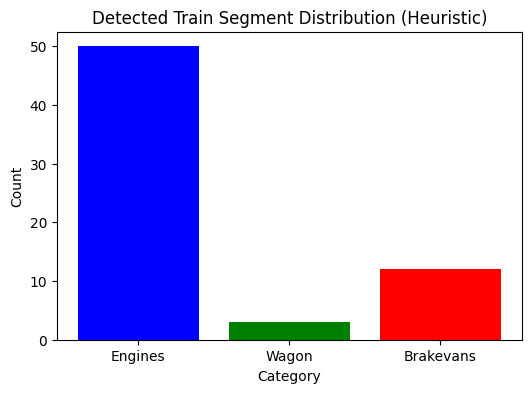

✅ Coverage Check:
Total Frames Extracted: 74
Total Segments Detected: 65
Coverage Ratio: 0.88 (segments per frame)
✅ Performance summary saved: Model_Performance_Summary_Heuristic.txt


In [24]:
# ==============================
# Section 6: Model Performance Insights (No Labels)
# ==============================
# 1. Category distribution (bar chart)
plt.figure(figsize=(6,4))
plt.bar(category_counts.keys(), category_counts.values(), color=['blue','green','red'])
plt.title("Detected Train Segment Distribution (Heuristic)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.savefig("Category_Distribution_Heuristic.png")
plt.show()

# 2. Frame coverage check
print("✅ Coverage Check:")
print(f"Total Frames Extracted: {total_frames}")
print(f"Total Segments Detected: {sum(category_counts.values())}")

if sum(category_counts.values()) == 0:
    print("⚠️ Warning: No train segments detected. Model may be misfiring or ROI is too strict.")
    coverage_ratio = 0
else:
    coverage_ratio = sum(category_counts.values()) / total_frames
    print(f"Coverage Ratio: {coverage_ratio:.2f} (segments per frame)")

# 3. Save summary as text
with open("Model_Performance_Summary_Heuristic.txt", "w") as f:
    f.write("Train Segment Detection Summary (Heuristic)\n")
    f.write("===========================================\n")
    for k,v in category_counts.items():
        f.write(f"{k}: {v}\n")
    f.write(f"Total Frames: {total_frames}\n")
    f.write(f"Total Segments Detected: {sum(category_counts.values())}\n")
    f.write(f"Coverage Ratio: {coverage_ratio:.2f}\n")

print("✅ Performance summary saved: Model_Performance_Summary_Heuristic.txt")